# Predicting Sleep Efficiency



## Introduction 

Sleep is extremely important for maintaining good health, as important as healthy diet and consistent exercise. (U.S. Department of Health and Human Services ,2022). Insufficient sleep can lead to serious medical conditions such as cardiovascular disease, diabetes, obesity and dementia. However, a good sleep is not how many hours spent in bed; therefore, the model will be predicting sleep efficiency, rather than sleep duration.
## Dataset
The dataset chosen to analyse sleep patterns and efficiency was pulled from [Kaggle-Sleep Efficiency](https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency).

Introduce all the variables in the data set:
- **Age** : age of individual
- **Gender** : male / female
- **Bedtime** : time individual goes to bed each night
- **Wakeup time** : time individual wakes up each morning
- **sleep duration** : total amount of time slept
- **REM** : percentage of time spent in REM
- **deep_sleep** : percent of time spent in deep sleep
- **light_sleep** : percent of time spent in light sleep
- **awakenings** : number of times individual wakes up at night
- **caffeine consumption** : amount of caffeine consumed in mg 24 hours prior to bed time
- **alcohol consumption** : amount of alcohol in Oz. consumed 24 hours prior to bed time
- **smoke** : whether individual smokes 
- **exercise** : number of times exercised weekly

The models I will use to predict sleep efficiency in individuals will be linear regression and random forest regression.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Loading the data set and cleaning up dataframe by renaming columns and selecting variables needed.

In [57]:
sleep = pd.read_csv("Sleep_Efficiency.csv")

In [58]:
sleep.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [59]:
#rename columns
sleep =  sleep.rename(columns={'Wakeup time': 'wakeup_time', 'Sleep duration': 'sleep_duration', 
                               'Sleep efficiency' : 'sleep_efficiency', 'REM sleep percentage' : 'REM',
                               'Deep sleep percentage' : 'deep_sleep', 'Light sleep percentage' : 'light_sleep',
                               'Caffeine consumption' : 'caffeine_intake', 'Alcohol consumption' : 'alcohol_intake',
                               'Smoking status' : 'smoke', 'Exercise frequency' : 'exercise'})

In [60]:
#select variables

sleep1 = sleep[['Age','Gender','Bedtime','wakeup_time','REM', 'deep_sleep','light_sleep','sleep_duration', 'sleep_efficiency','Awakenings', 'caffeine_intake', 'alcohol_intake', 'smoke', 'exercise']]

In [61]:
sleep1.shape

(452, 14)

Here, I will drop rows with any columns that have no data and are N/A.

In [62]:
sleep2 = sleep1.dropna()
sleep2.shape

(388, 14)

In [63]:
sleep2.head()

,Age,Gender,Bedtime,wakeup_time,REM,deep_sleep,light_sleep,sleep_duration,sleep_efficiency,Awakenings,caffeine_intake,alcohol_intake,smoke,exercise
0,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,18,70,12,6.0,0.88,0.0,0.0,0.0,Yes,3.0
1,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,19,28,53,7.0,0.66,3.0,0.0,3.0,Yes,3.0
2,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,20,70,10,8.0,0.89,1.0,0.0,0.0,No,3.0
3,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,23,25,52,6.0,0.51,3.0,50.0,5.0,Yes,1.0
4,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,27,55,18,8.0,0.76,3.0,0.0,3.0,No,3.0


I will select only the hour and minutes of the time from bedtime and wakeup_time, and create a new column for bedtime and wakeup time. Gender and smoke will also have a new column created, where if an individual is a male, they will be given a value of 1. An individual who smokes will also be given a value of 1, and 0 for non-smokers.

In [64]:
def hour(x):
    time_only = x.split()[1]
    time_arr = time_only.split(':')
    return int(time_arr[0])

def min(x):
    time_only = x.split()[1]
    time_arr = time_only.split(':')
    if time_arr[1] == "30":
        return 0.5
    else:
        return 0

sleep2['bedtime_hr'] = sleep2.apply(lambda row: hour(row.Bedtime), axis=1)
sleep2['bedtime_min'] = sleep2.apply(lambda row: min(row.Bedtime), axis=1)
sleep2['wakeup_hr'] = sleep2.apply(lambda row: hour(row.wakeup_time), axis=1)
sleep2['wakeup_min'] = sleep2.apply(lambda row: min(row.wakeup_time), axis=1)

sleep2['bedtime2'] = sleep2['bedtime_min']+sleep2['bedtime_hr'] 
sleep2['wakeup2'] = sleep2['wakeup_min']+sleep2['wakeup_hr'] 

sleep2['gender2'] = sleep2['Gender'].apply(lambda x:1 if x == 'Male' else 0)
sleep2['smoking'] = sleep2['smoke'].apply(lambda x:1 if x == 'Yes' else 0)


sleep2.head()

,Age,Gender,Bedtime,wakeup_time,REM,deep_sleep,light_sleep,sleep_duration,sleep_efficiency,Awakenings,...,smoke,exercise,bedtime_hr,bedtime_min,wakeup_hr,wakeup_min,bedtime2,wakeup2,gender2,smoking
0,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,18,70,12,6.0,0.88,0.0,...,Yes,3.0,1,0.0,7,0.0,1.0,7.0,0,1
1,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,19,28,53,7.0,0.66,3.0,...,Yes,3.0,2,0.0,9,0.0,2.0,9.0,1,1
2,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,20,70,10,8.0,0.89,1.0,...,No,3.0,21,0.5,5,0.5,21.5,5.5,0,0
3,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,23,25,52,6.0,0.51,3.0,...,Yes,1.0,2,0.5,8,0.5,2.5,8.5,0,1
4,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,27,55,18,8.0,0.76,3.0,...,No,3.0,1,0.0,9,0.0,1.0,9.0,1,0


To visualize the data set, I created plots below to show what the population looks like. Here, I let smokers be the colour red, and non-smokers be blue. We can see that light_sleep, number of awakenings have stronger negative relationships with sleep efficiency, while deep_sleep and sleep efficiency are positively correlated. There seems to be no relationship between sleep efficiency and bed time or wakeup time. It's interesting to observe that although points seemed to be randomly and evenly spread, nearly all individuals who experience low quality sleep (low sleep efficiency under 0.6) are all smokers. 

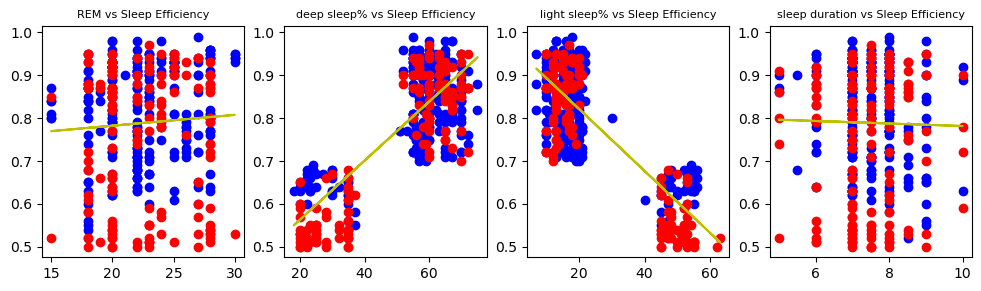

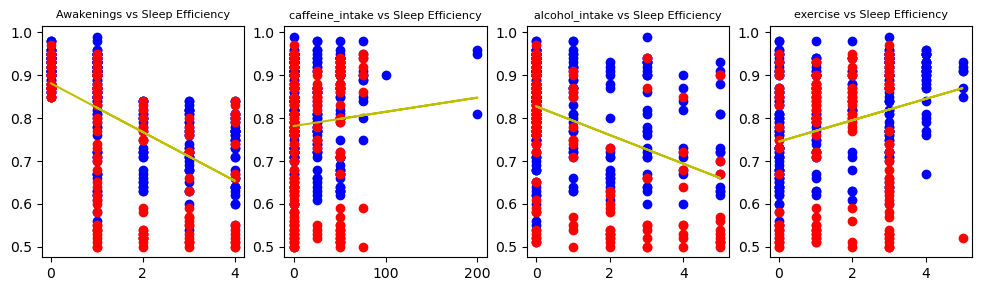

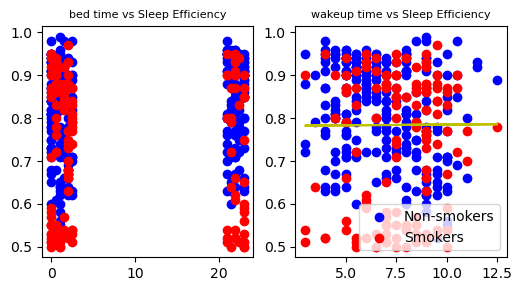

In [65]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
fig, axs1 = plt.subplots(1, 4, figsize=(12, 3))
fig, axs2 = plt.subplots(1, 2, figsize=(6, 3))


smokers = sleep2[sleep2['smoke'] == 'Yes']
non_smokers = sleep2[sleep2['smoke'] == 'No']

sleepplots = [sleep2["REM"],sleep2["deep_sleep"],sleep2["light_sleep"],sleep2["sleep_duration"]]
sleepplots2 = [sleep2["Awakenings"],sleep2["caffeine_intake"],sleep2["alcohol_intake"],sleep2["exercise"]]
sleepplots3 = [sleep2["bedtime2"], sleep2["wakeup2"]]
             
list1 = ["REM", "deep_sleep", "light_sleep", "sleep_duration"]
list2  = ["Awakenings", "caffeine_intake", "alcohol_intake", "exercise"]

for i in range(0,4):
    axs[i].scatter(non_smokers[list1[i]], non_smokers["sleep_efficiency"], color="blue", label = "Non-smokers")
    axs[i].scatter(smokers[list1[i]], smokers['sleep_efficiency'], color='red', label='Smokers')
    m, b = np.polyfit(sleepplots[i], sleep2["sleep_efficiency"], 1)
    axs[i].plot(sleepplots[i], m*sleepplots[i]+b, 'y')
    
for i in range(0,4):
    axs1[i].scatter(non_smokers[list2[i]], non_smokers["sleep_efficiency"], color="blue", label = "Non-smokers")
    axs1[i].scatter(smokers[list2[i]], smokers['sleep_efficiency'], color='red', label='Smokers')
    m, b = np.polyfit(sleepplots2[i], sleep2["sleep_efficiency"], 1)
    axs1[i].plot(sleepplots2[i], m*sleepplots2[i]+b, 'y')


axs[0].set_title("REM vs Sleep Efficiency",fontdict={'fontsize': 8})
axs[1].set_title("deep sleep% vs Sleep Efficiency", fontdict={'fontsize': 8})
axs[2].set_title("light sleep% vs Sleep Efficiency", fontdict={'fontsize': 8})
axs[3].set_title("sleep duration vs Sleep Efficiency", fontdict={'fontsize': 8})


axs1[0].set_title("Awakenings vs Sleep Efficiency",fontdict={'fontsize': 8})
axs1[1].set_title("caffeine_intake vs Sleep Efficiency", fontdict={'fontsize': 8})
axs1[2].set_title("alcohol_intake vs Sleep Efficiency", fontdict={'fontsize': 8})
axs1[3].set_title("exercise vs Sleep Efficiency", fontdict={'fontsize': 8})


axs2[0].scatter(non_smokers["bedtime2"], non_smokers["sleep_efficiency"], color="blue", label = "Non-smokers")
axs2[0].scatter(smokers["bedtime2"], smokers['sleep_efficiency'], color='red', label='Smokers')
m, b = np.polyfit(sleepplots2[0], sleep2["sleep_efficiency"], 1)
axs2[0].set_title("bed time vs Sleep Efficiency", fontdict={'fontsize': 8})

axs2[1].scatter(non_smokers["wakeup2"], non_smokers["sleep_efficiency"], color="blue", label = "Non-smokers")
axs2[1].scatter(smokers["wakeup2"], smokers['sleep_efficiency'], color='red', label='Smokers')
m, b = np.polyfit(sleepplots2[1], sleep2["sleep_efficiency"], 1)
axs2[1].plot(sleepplots3[1], m*sleepplots3[1]+b, 'y')
axs2[1].set_title("wakeup time vs Sleep Efficiency", fontdict={'fontsize': 8})



plt.legend()
plt.show()

Next, I did the same thing except now we have females in red, and males in blue.

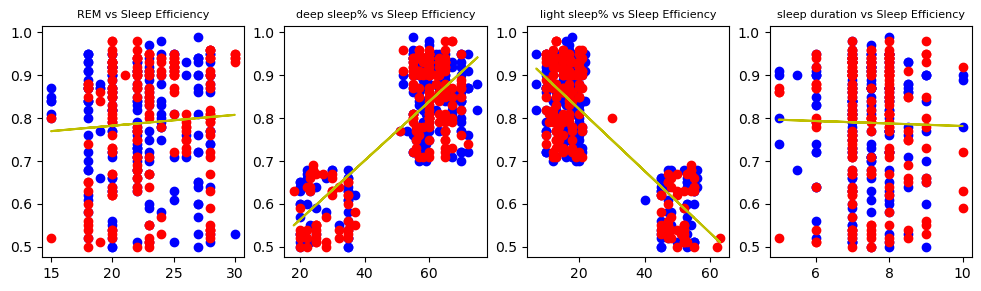

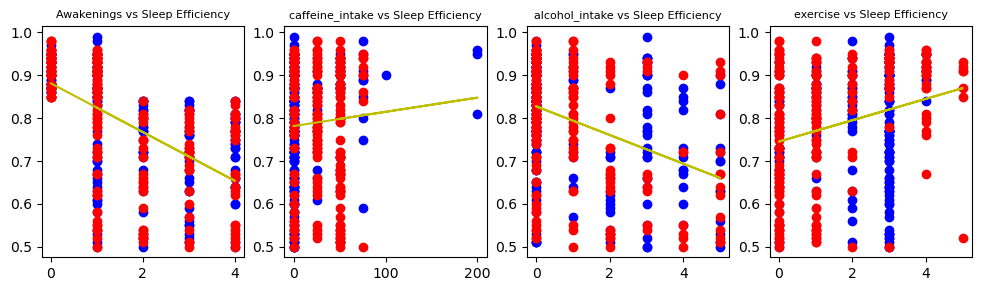

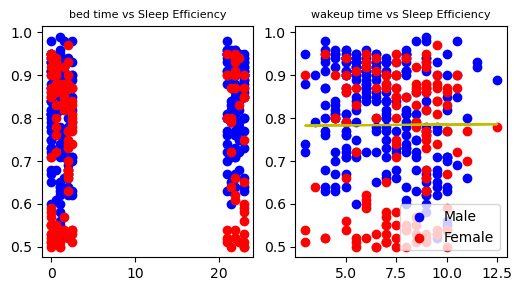

In [66]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
fig, axs1 = plt.subplots(1, 4, figsize=(12, 3))
fig, axs2 = plt.subplots(1, 2, figsize=(6, 3))

sleepplots = [sleep2["REM"],sleep2["deep_sleep"],sleep2["light_sleep"],sleep2["sleep_duration"]]
sleepplots2 = [sleep2["Awakenings"],sleep2["caffeine_intake"],sleep2["alcohol_intake"],sleep2["exercise"]]
sleepplots3 = [sleep2["bedtime2"], sleep2["wakeup2"]]
             
list1 = ["REM", "deep_sleep", "light_sleep", "sleep_duration"]
list2  = ["Awakenings", "caffeine_intake", "alcohol_intake", "exercise"]

female = sleep2[sleep2['Gender'] == 'Female']
male = sleep2[sleep2['Gender'] == 'Male']

for i in range(0,4):
    axs[i].scatter(male[list1[i]], male["sleep_efficiency"], color="blue", label = "Male")
    axs[i].scatter(female[list1[i]], female['sleep_efficiency'], color='red', label='Female')
    m, b = np.polyfit(sleepplots[i], sleep2["sleep_efficiency"], 1)
    axs[i].plot(sleepplots[i], m*sleepplots[i]+b, 'y')
    
for i in range(0,4):
    axs1[i].scatter(male[list2[i]], male["sleep_efficiency"], color="blue", label = "Male")
    axs1[i].scatter(female[list2[i]], female['sleep_efficiency'], color='red', label='Female')
    m, b = np.polyfit(sleepplots2[i], sleep2["sleep_efficiency"], 1)
    axs1[i].plot(sleepplots2[i], m*sleepplots2[i]+b, 'y')


female = sleep2[sleep2['Gender'] == 'Female']
male = sleep2[sleep2['Gender'] == 'Male']


axs[0].set_title("REM vs Sleep Efficiency",fontdict={'fontsize': 8})
axs[1].set_title("deep sleep% vs Sleep Efficiency", fontdict={'fontsize': 8})
axs[2].set_title("light sleep% vs Sleep Efficiency", fontdict={'fontsize': 8})
axs[3].set_title("sleep duration vs Sleep Efficiency", fontdict={'fontsize': 8})


axs1[0].set_title("Awakenings vs Sleep Efficiency",fontdict={'fontsize': 8})
axs1[1].set_title("caffeine_intake vs Sleep Efficiency", fontdict={'fontsize': 8})
axs1[2].set_title("alcohol_intake vs Sleep Efficiency", fontdict={'fontsize': 8})
axs1[3].set_title("exercise vs Sleep Efficiency", fontdict={'fontsize': 8})

axs2[0].scatter(non_smokers["bedtime2"], non_smokers["sleep_efficiency"], color="blue", label = "Male")
axs2[0].scatter(smokers["bedtime2"], smokers['sleep_efficiency'], color='red', label='Female')
m, b = np.polyfit(sleepplots2[0], sleep2["sleep_efficiency"], 1)
axs2[0].set_title("bed time vs Sleep Efficiency", fontdict={'fontsize': 8})

axs2[1].scatter(non_smokers["wakeup2"], non_smokers["sleep_efficiency"], color="blue", label = "Male")
axs2[1].scatter(smokers["wakeup2"], smokers['sleep_efficiency'], color='red', label='Female')
m, b = np.polyfit(sleepplots2[1], sleep2["sleep_efficiency"], 1)
axs2[1].plot(sleepplots3[1], m*sleepplots3[1]+b, 'y')
axs2[1].set_title("wakeup time vs Sleep Efficiency", fontdict={'fontsize': 8})


plt.legend()
plt.show()

I then did 2 box plots, one for smoking status and sleep efficiency, and one for gender and sleep efficiency.

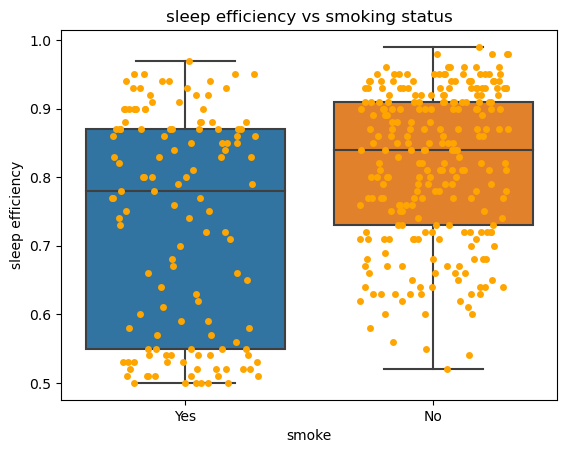

In [67]:
sns.boxplot(y="sleep_efficiency", x="smoke", data = sleep2)
sns.stripplot(x='smoke', y='sleep_efficiency', data=sleep2, color="orange", jitter=0.3, size=5)

plt.ylabel("sleep efficiency")
plt.title("sleep efficiency vs smoking status")
plt.show()

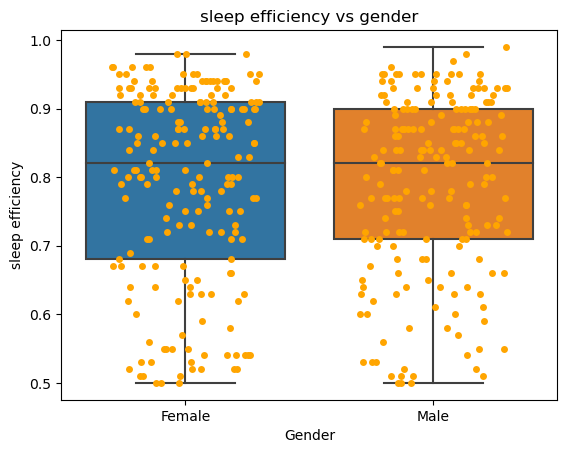

In [68]:
sns.boxplot(y="sleep_efficiency", x="Gender", data = sleep2)
sns.stripplot(x='Gender', y='sleep_efficiency', data=sleep2, color="orange", jitter=0.3, size=5)

plt.ylabel("sleep efficiency")
plt.title("sleep efficiency vs gender")
plt.show()

## Modelling

### 1. Linear Regression model

In [69]:
X = sleep2[['Age', 'sleep_duration','Awakenings','caffeine_intake', 
            'alcohol_intake', 'exercise','bedtime2','wakeup2','gender2',
            'smoking','REM','deep_sleep','light_sleep']]
y = sleep2[['sleep_efficiency']]

Split the data set into training set and testing set, 70% and 30%.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [71]:
import statsmodels.api as sm

estimate = sm.OLS(y_train, X_train)
fit = estimate.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:       sleep_efficiency   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     78.00
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           1.46e-78
Time:                        05:16:29   Log-Likelihood:                 369.32
No. Observations:                 271   AIC:                            -712.6
Df Residuals:                     258   BIC:                            -665.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                 0.0010      0.000     

We drop caffeine, sleep duration, bedtime, wakeup time, gender, and alcohol intake for their p-value is greater than 0.05.

In [72]:
X_train2 = X_train[['Age','Awakenings','exercise','smoking',
            'REM','deep_sleep','light_sleep']]
X_test2 = X_test[['Age','Awakenings','exercise','smoking',
            'REM','deep_sleep','light_sleep']]

In [73]:
estimate2 = sm.OLS(y_train, X_train2)
fit2 = estimate2.fit()
print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:       sleep_efficiency   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     148.4
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           1.38e-81
Time:                        05:16:29   Log-Likelihood:                 361.65
No. Observations:                 271   AIC:                            -709.3
Df Residuals:                     264   BIC:                            -684.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Age             0.0007      0.000      2.255      

In [74]:
lm = linear_model.LinearRegression()


a = lm.fit(X_train2, y_train)

predicted_train = lm.predict(X_train2)
predicted = lm.predict(X_test2)

rmse_train = np.sqrt(mean_squared_error(y_train,predicted_train))
rmse_train


0.06370772128531554

Text(0.5, 1.0, 'Linear regression predicted vs true sleep efficiency')

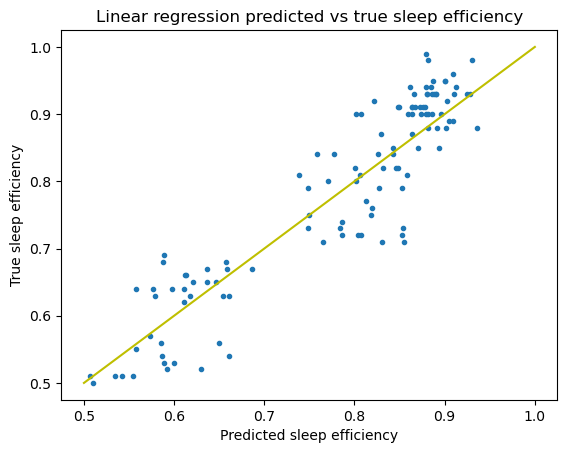

In [75]:
plt.plot(predicted, y_test, '.')
plt.plot([0.5, 1], [0.5,1], 'y')
plt.xlabel("Predicted sleep efficiency")
plt.ylabel("True sleep efficiency")
plt.title("Linear regression predicted vs true sleep efficiency")

Above I plotted the predicted value of sleep efficiency vs the true value of sleep efficiency. We can see that the graph is close to being linear, and a best fit line with a slope of 1 fits well on the graph.

### 2. Random Forests

In [76]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train2, y_train)

predict_rf = rf.predict(X_test2)
rmse_rf = np.sqrt(mean_squared_error(predict_rf,y_test))
rmse_rf

0.04881013450736216

Text(0.5, 1.0, 'Random forests predicted vs true sleep efficiency')

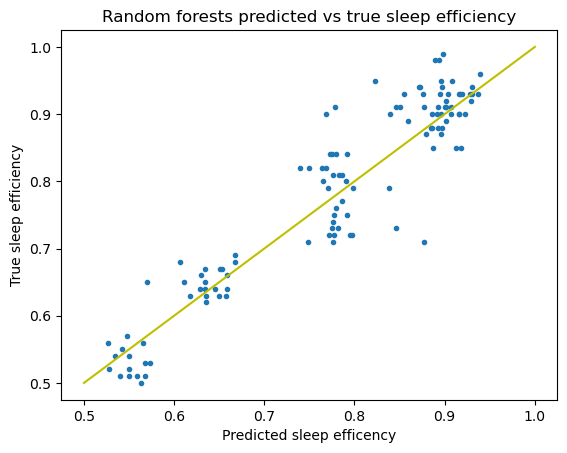

In [77]:
plt.plot(predict_rf, y_test, '.')
plt.plot([0.5, 1], [0.5,1], 'y')
plt.xlabel("Predicted sleep efficency")
plt.ylabel("True sleep efficiency")
plt.title("Random forests predicted vs true sleep efficiency")

Again, I plotted the predicted value of sleep efficiency vs the true value of sleep efficiency. This time, the datapoints appear to be much closer to the best fit line, which is consistent with the fact that the RMSE is lower for random forest model compared to our linear regression model.

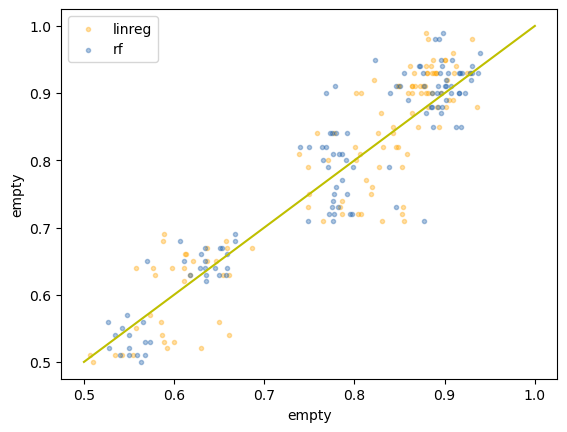

In [78]:
plt.scatter(predicted,y_test, c= '#FFA500', alpha=0.35, s=9)
plt.scatter(predict_rf,y_test, c= '#165aa7', alpha=0.35, s=9)

plt.plot([0.5, 1], [0.5,1], 'y')
plt.legend(["linreg", "rf"])
plt.xlabel("empty")
plt.ylabel("empty")
plt.show()

The graph above shows the predicted value vs the true value for the linear regression model, and random forests model. We can see that the random forests model has data points that are closer to the graph $y=x$

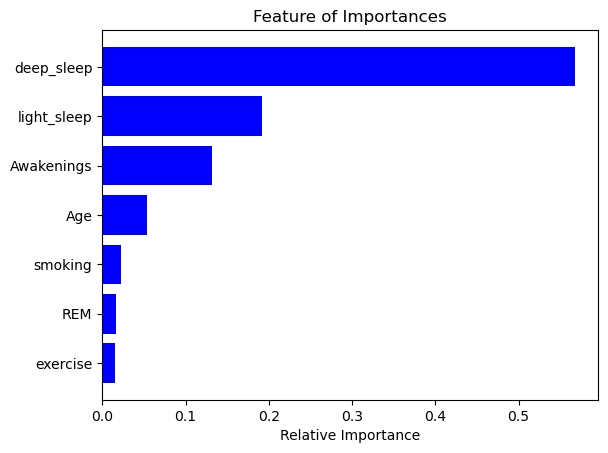

In [79]:
#add feature of importance chart

predictors = ['Age','Awakenings','exercise','smoking',
             'REM','deep_sleep','light_sleep']

variables = rf.feature_importances_
feature = np.argsort(variables)

plt.title('Feature of Importances')
plt.barh(range(len(feature)), variables[feature], color='b', align='center')
plt.yticks(range(len(feature)), [predictors[i] for i in feature])
plt.xlabel('Relative Importance')
plt.show()




I added a feature of importance chart to visualize how important each predictor was for this model. It appears that the percent of time spent in deep sleep, light sleep, and number of awakenings are the three most important factors that determine an individual's sleep efficiency.

### Observations

Based on the two models used to predict sleep efficiency, the random forests model was the most accurate with the lowest root mean squared error. By the feature of importances table, we can see that deep sleep is the most important predictor associated with high sleep efficiency.

### References

U.S. Department of Health and Human Services. (2022, July 15). Good sleep for good health. National Institutes of Health. 

Bin, Y. S. (2016). Is sleep quality more important than sleep duration for public health? Sleep, 39(9), 1629–1630. 